In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
#from lightgbm import  log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

In [4]:
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [5]:
train_df.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [6]:
train_df.shape

(18524, 9)

In [7]:
test_df.shape

(6175, 8)

In [8]:
train_df.head(10)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
5,5,2.0,No,8.0,5.0,No,NaN,3.0,Extrovert
6,6,1.0,No,8.0,NaN,No,NaN,4.0,Extrovert
7,7,2.0,No,8.0,3.0,No,4.0,5.0,Extrovert
8,8,4.0,Yes,2.0,1.0,NaN,0.0,2.0,Introvert
9,9,1.0,No,8.0,6.0,No,14.0,9.0,Extrovert


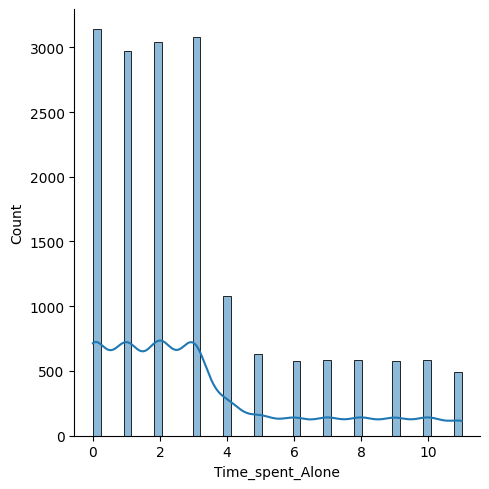

In [9]:
sns.displot(train_df['Time_spent_Alone'],kde = True)

Text(0.5, 1.0, 'Social_event_attendance vs Personlaity')

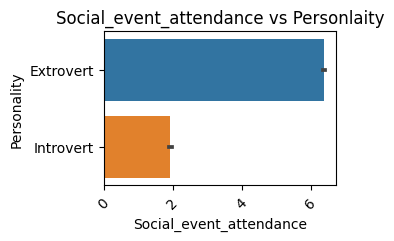

In [10]:
#sns.pairplot(train_df)
#plt.show()
plt.figure(figsize=(3,2))
sns.barplot(x=train_df['Social_event_attendance'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Social_event_attendance')
plt.ylabel('Personality')
plt.title('Social_event_attendance vs Personlaity')

Text(0.5, 1.0, 'Time_spent_Alone vs Personlaity')

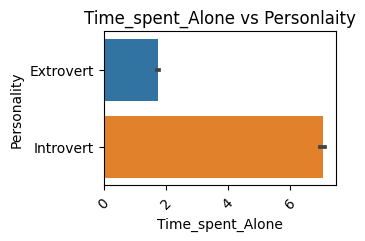

In [11]:
plt.figure(figsize=(3,2))
sns.barplot(x=train_df['Time_spent_Alone'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Time_spent_Alone')
plt.ylabel('Personality')
plt.title('Time_spent_Alone vs Personlaity')

Text(0.5, 1.0, 'Going_outside vs Personlaity')

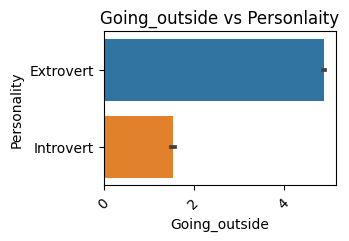

In [12]:
plt.figure(figsize=(3,2))
sns.barplot(x=train_df['Going_outside'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Going_outside')
plt.ylabel('Personality')
plt.title('Going_outside vs Personlaity')

Text(0.5, 1.0, 'Friends_circle_size vs Personlaity')

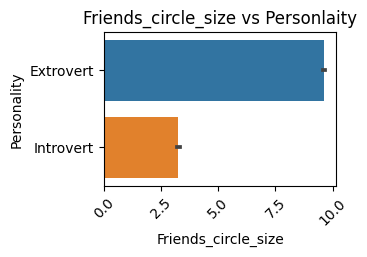

In [13]:
plt.figure(figsize=(3,2))
sns.barplot(x=train_df['Friends_circle_size'], y=train_df['Personality'])
plt.xticks(rotation= 45)
plt.xlabel('Friends_circle_size')
plt.ylabel('Personality')
plt.title('Friends_circle_size vs Personlaity')

In [14]:
y = train_df.iloc[:, -1]
y.head()

0    Extrovert
1    Extrovert
2    Introvert
3    Extrovert
4    Extrovert
Name: Personality, dtype: object

In [15]:
X = train_df.iloc[:, :-1]
X.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,0,0.0,No,6.0,4.0,No,15.0,5.0
1,1,1.0,No,7.0,3.0,No,10.0,8.0
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0
3,3,3.0,No,7.0,3.0,No,11.0,5.0
4,4,1.0,No,4.0,4.0,No,13.0,NaN


In [16]:
cat_columns = ['Stage_fear', 'Drained_after_socializing']

In [17]:
train_df[cat_columns].isnull().sum()

Stage_fear                   1893
Drained_after_socializing    1149
dtype: int64

In [18]:
train_df['Stage_fear'].unique()

array(['No', 'Yes', nan], dtype=object)

In [19]:
train_df_fill = train_df.copy()
for col in cat_columns:
    if col in train_df_fill.columns: 
        mode_val = train_df_fill[col].mode()[0]
        train_df_fill[col] = train_df_fill[col].fillna(mode_val)
print("\nMethod 1: Filled using a loop for each column's mode:")
print(train_df_fill)


Method 1: Filled using a loop for each column's mode:
          id  Time_spent_Alone Stage_fear  Social_event_attendance  \
0          0               0.0         No                      6.0   
1          1               1.0         No                      7.0   
2          2               6.0        Yes                      1.0   
3          3               3.0         No                      7.0   
4          4               1.0         No                      4.0   
...      ...               ...        ...                      ...   
18519  18519               3.0         No                      7.0   
18520  18520               1.0         No                      6.0   
18521  18521               7.0        Yes                      1.0   
18522  18522               NaN        Yes                      1.0   
18523  18523               1.0         No                      8.0   

       Going_outside Drained_after_socializing  Friends_circle_size  \
0                4.0             

In [20]:
test_df_fill = test_df.copy()
for col in cat_columns:
    if col in test_df_fill.columns: 
        mode_val = test_df_fill[col].mode()[0]
        test_df_fill[col] = test_df_fill[col].fillna(mode_val)
print("\nMethod 1: Filled using a loop for each column's mode:")
print(test_df_fill.head(10))


Method 1: Filled using a loop for each column's mode:
      id  Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0  18524               3.0         No                      7.0            4.0   
1  18525               NaN        Yes                      0.0            0.0   
2  18526               3.0         No                      5.0            6.0   
3  18527               3.0         No                      4.0            4.0   
4  18528               9.0        Yes                      1.0            2.0   
5  18529               2.0         No                      5.0            3.0   
6  18530               3.0         No                      4.0            5.0   
7  18531              11.0        Yes                      2.0            1.0   
8  18532               2.0         No                      6.0            NaN   
9  18533               8.0         No                      2.0            1.0   

  Drained_after_socializing  Friends_circle_size  Pos

In [21]:
train_df_fill[cat_columns].isna().sum()

Stage_fear                   0
Drained_after_socializing    0
dtype: int64

In [22]:
test_df_fill[cat_columns].isna().sum()

Stage_fear                   0
Drained_after_socializing    0
dtype: int64

In [23]:
numerical_cols = [col for col in X.columns if col not in cat_columns]
numerical_cols

['id',
 'Time_spent_Alone',
 'Social_event_attendance',
 'Going_outside',
 'Friends_circle_size',
 'Post_frequency']

In [24]:
for col in numerical_cols:
    if col in train_df_fill.columns: # Ensure the column exists
        # Calculate the mode for the current column. .mode()[0] handles ties by taking the first mode.
        median_val = train_df_fill[col].median()
        train_df_fill[col] = train_df_fill[col].fillna(median_val)
print("\nMethod 1: Filled using a loop for each column's mode:")
print(train_df_fill)


Method 1: Filled using a loop for each column's mode:
          id  Time_spent_Alone Stage_fear  Social_event_attendance  \
0          0               0.0         No                      6.0   
1          1               1.0         No                      7.0   
2          2               6.0        Yes                      1.0   
3          3               3.0         No                      7.0   
4          4               1.0         No                      4.0   
...      ...               ...        ...                      ...   
18519  18519               3.0         No                      7.0   
18520  18520               1.0         No                      6.0   
18521  18521               7.0        Yes                      1.0   
18522  18522               2.0        Yes                      1.0   
18523  18523               1.0         No                      8.0   

       Going_outside Drained_after_socializing  Friends_circle_size  \
0                4.0             

In [25]:
for col in numerical_cols:
    if col in test_df_fill.columns: # Ensure the column exists
        # Calculate the mode for the current column. .mode()[0] handles ties by taking the first mode.
        median_val = test_df_fill[col].median()
        test_df_fill[col] = test_df_fill[col].fillna(median_val)
print("\nMethod 1: Filled using a loop for each column's mode:")
print(test_df_fill.head())


Method 1: Filled using a loop for each column's mode:
      id  Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0  18524               3.0         No                      7.0            4.0   
1  18525               2.0        Yes                      0.0            0.0   
2  18526               3.0         No                      5.0            6.0   
3  18527               3.0         No                      4.0            4.0   
4  18528               9.0        Yes                      1.0            2.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency  
0                        No                  6.0             5.0  
1                       Yes                  5.0             1.0  
2                        No                 15.0             9.0  
3                        No                  5.0             6.0  
4                       Yes                  1.0             1.0  


In [26]:
train_df_fill[numerical_cols].isna().sum()

id                         0
Time_spent_Alone           0
Social_event_attendance    0
Going_outside              0
Friends_circle_size        0
Post_frequency             0
dtype: int64

In [27]:
test_df_fill[numerical_cols].isna().sum()

id                         0
Time_spent_Alone           0
Social_event_attendance    0
Going_outside              0
Friends_circle_size        0
Post_frequency             0
dtype: int64

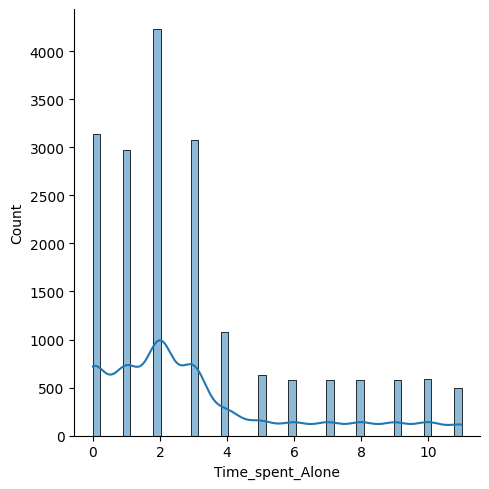

In [28]:
sns.displot(train_df_fill['Time_spent_Alone'],kde = True)

In [29]:
train_df_fill.head(10)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,No,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,5.0,Extrovert
5,5,2.0,No,8.0,5.0,No,8.0,3.0,Extrovert
6,6,1.0,No,8.0,4.0,No,8.0,4.0,Extrovert
7,7,2.0,No,8.0,3.0,No,4.0,5.0,Extrovert
8,8,4.0,Yes,2.0,1.0,No,0.0,2.0,Introvert
9,9,1.0,No,8.0,6.0,No,14.0,9.0,Extrovert


In [30]:
test_df_fill.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,5.0
1,18525,2.0,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [31]:
train_df.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [32]:
test_df.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [33]:
lenc = LabelEncoder()

In [34]:
for i in cat_columns:
    train_df_fill[i] = lenc.fit_transform(train_df_fill[i])
train_df_fill['Personality'] = lenc.fit_transform(train_df_fill['Personality'])

In [35]:
train_df_fill.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0,6.0,4.0,0,15.0,5.0,0
1,1,1.0,0,7.0,3.0,0,10.0,8.0,0
2,2,6.0,1,1.0,0.0,0,3.0,0.0,1
3,3,3.0,0,7.0,3.0,0,11.0,5.0,0
4,4,1.0,0,4.0,4.0,0,13.0,5.0,0


In [36]:
for i in cat_columns:
    test_df_fill[i] = lenc.fit_transform(test_df_fill[i])
#test_df_fill['Personality'] = lenc.fit_transform(test_df_fill['Personality'])

In [37]:
X_train_df = train_df_fill.iloc[:, :-1]
X_train_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,0,0.0,0,6.0,4.0,0,15.0,5.0
1,1,1.0,0,7.0,3.0,0,10.0,8.0
2,2,6.0,1,1.0,0.0,0,3.0,0.0
3,3,3.0,0,7.0,3.0,0,11.0,5.0
4,4,1.0,0,4.0,4.0,0,13.0,5.0


In [38]:
from sklearn.preprocessing import StandardScaler
X_train_df[numerical_cols] = StandardScaler().fit_transform(X_train_df[numerical_cols])
test_df_fill[numerical_cols] = StandardScaler().fit_transform(test_df_fill[numerical_cols])
print(X_train_df.head())

         id  Time_spent_Alone  Stage_fear  Social_event_attendance  \
0 -1.731957         -1.049913           0                 0.282102   
1 -1.731770         -0.707327           0                 0.657346   
2 -1.731583          1.005601           1                -1.594120   
3 -1.731396         -0.022156           0                 0.657346   
4 -1.731209         -0.707327           0                -0.468387   

   Going_outside  Drained_after_socializing  Friends_circle_size  \
0      -0.020620                          0             1.707463   
1      -0.525859                          0             0.488383   
2      -2.041578                          0            -1.218331   
3      -0.525859                          0             0.732199   
4      -0.020620                          0             1.219831   

   Post_frequency  
0        0.006002  
1        1.085490  
2       -1.793144  
3        0.006002  
4        0.006002  


In [39]:
X_train_df.drop('id',axis=1,inplace=True)
X_train_df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,-1.049913,0,0.282102,-0.020620,0,1.707463,0.006002
1,-0.707327,0,0.657346,-0.525859,0,0.488383,1.085490
2,1.005601,1,-1.594120,-2.041578,0,-1.218331,-1.793144
3,-0.022156,0,0.657346,-0.525859,0,0.732199,0.006002
4,-0.707327,0,-0.468387,-0.020620,0,1.219831,0.006002


In [40]:
y_train_df = train_df_fill.iloc[:,-1]
y_train_df.head()

0    0
1    0
2    1
3    0
4    0
Name: Personality, dtype: int64

In [41]:
X_test = test_df_fill.copy()
X_test.drop('id',axis=1,inplace=True)
X_test.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,-0.013818,0,0.648471,-0.017789,0,-0.493132,-0.009761
1,-0.359281,1,-1.974603,-2.051989,1,-0.738724,-1.453434
2,-0.013818,0,-0.100979,0.999311,0,1.717194,1.433912
3,-0.013818,0,-0.475703,-0.017789,0,-0.738724,0.351157
4,2.058955,1,-1.599878,-1.034889,1,-1.721091,-1.453434


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_df, y_train_df, test_size=0.3, random_state=42
)

In [43]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(12966, 7)
(5558, 7)
(12966,)
(5558,)


In [44]:
from sklearn.linear_model import LogisticRegression


In [45]:
lr = LogisticRegression(solver='liblinear', max_iter=200)

In [46]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=200, solver='liblinear')

In [47]:
y_pred = lr.predict(X_valid)

In [48]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_valid,y_pred)

In [49]:
print(f"Model Accuracy: {accuracy: .3f}")

Model Accuracy:  0.967


In [50]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random',max_depth=3,min_samples_split= 2)
clf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0,
                       splitter='random')

In [51]:
y_pred_Dt = clf.predict(X_valid)
accuracy_dt = accuracy_score(y_pred_Dt,y_valid)
print(f"Model Accuracy: {accuracy_dt:.4f}")

Model Accuracy: 0.9665


In [52]:
from sklearn.model_selection import cross_val_score
accuracy_cv1 = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,n_jobs=1)
print(accuracy_cv1.mean())

0.9685337483461358


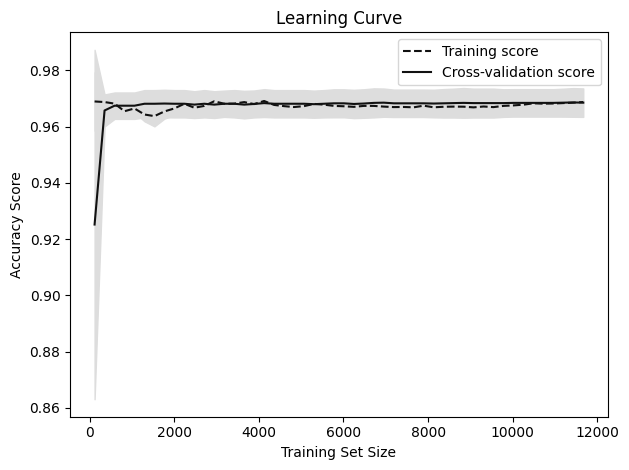

In [53]:
from sklearn.model_selection import learning_curve
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [54]:
train_df.shape

(18524, 9)

In [55]:
train_df['Personality'].value_counts()

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64

In [56]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # for binary classification
    n_estimators=200,             # Number of boosting rounds
    learning_rate=0.1,
    max_depth=3,
    eval_metric='logloss',        # Evaluation metric for early stopping
    use_label_encoder=False,      # Suppress a deprecation warning
    seed=42                 # for reproducibility
)


In [57]:
xgb_model.fit(X_train,y_train,
              eval_set=[(X_valid, y_valid)],  # Provide a validation set
                early_stopping_rounds=10,
              verbose=False 
             )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [58]:
y_pred_xgb = xgb_model.predict(X_valid)
accuracy_xgb = accuracy_score(y_valid, y_pred_xgb)

print(f"Model Accuracy: {accuracy_xgb:.4f}")

Model Accuracy: 0.9674



Feature Importances:


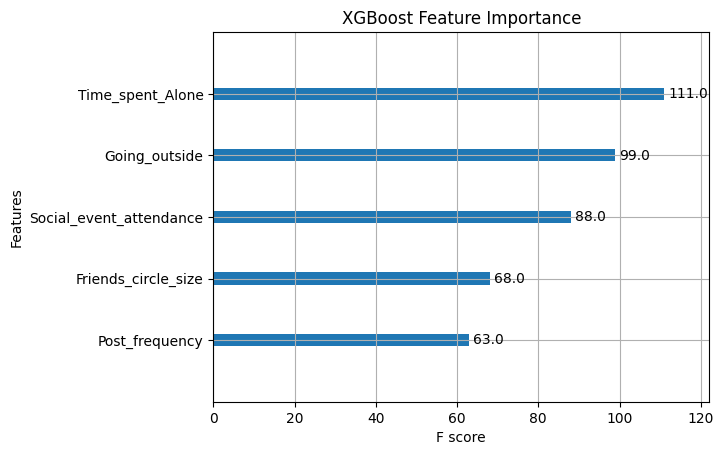

In [59]:
print("\nFeature Importances:")
xgb.plot_importance(xgb_model, max_num_features=5) 
plt.title("XGBoost Feature Importance")
plt.show()

In [60]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2]
}



# 4. Set up GridSearchCV
# cv=5 means 5-fold cross-validation.
# n_jobs=-1 uses all available CPU cores.
# verbose=1 shows progress.
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 5. Run the grid search
grid_search.fit(X_train, y_train)

# 6. Print the best results
print("Best Parameters found: ", grid_search.best_params_)
print("Best Cross-validation score: {:.4f}".format(grid_search.best_score_))

# You can now use the best estimator for predictions
best_model = grid_search.best_estimator_
accuracy_GridCV = best_model.score(X_valid, y_valid)
print(f"Valid set accuracy of the best model: {accuracy_GridCV:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters found:  {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Cross-validation score: 0.9695
Valid set accuracy of the best model: 0.9673


In [61]:
param_grid_lr = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'], # Solvers compatible with L1
        'C': [0.1, 1.0, 10.0]
    },
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear', 'saga'], # Solvers compatible with L2
        'C': [0.1, 1.0, 10.0]
    }
]

# 4. Set up and run GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    cv=10,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1 # Use all available cores
)

grid_search_lr.fit(X_train, y_train)

# 5. Print the best results
print("\nBest Parameters found: ", grid_search_lr.best_params_)
print("Best Cross-validation score: {:.4f}".format(grid_search_lr.best_score_))

#Using the best model from Logistics regression
best_model_lr = grid_search_lr.best_estimator_

accuracy_GridCV_lr = best_model_lr.score(X_valid, y_valid)
print(f"Valid set accuracy of the best model: {accuracy_GridCV_lr:.4f}")

Fitting 10 folds for each of 15 candidates, totalling 150 fits

Best Parameters found:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-validation score: 0.9692
Valid set accuracy of the best model: 0.9674


In [62]:
y_pred_final = best_model_lr.predict(X_test)
y_pred_final1 = best_model.predict(X_test)

In [63]:
 #If 'id' column is in the test set
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Include the 'id' column
    'Personality': y_pred_final1  # Predicted prices from your model
})
label_mapping = {0: 'Extrovert', 1: 'Introvert'}
submission_df['Personality'] = submission_df['Personality'].replace(label_mapping)

# Save the submission DataFrame to a CSV file
submission_df.to_csv('kaggle_submission.csv', index=False)

# Print message to indicate the submission file is ready
print("Submission file 'kaggle_submission.csv' is ready.")

Submission file 'kaggle_submission.csv' is ready.
